In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [8]:
tf.random.set_seed(13)

In [9]:
img_df = pd.read_csv("photos/image_labels.csv")
img_df.head()

,path,class,label,image_id
0,Alphabet_A_1.jpg,Alphabet_A,9,20
1,Alphabet_A_10.jpg,Alphabet_A,9,20
2,Alphabet_A_11.jpg,Alphabet_A,9,20
3,Alphabet_A_12.jpg,Alphabet_A,9,20
4,Alphabet_A_13.jpg,Alphabet_A,9,20


In [10]:
len(img_df)

1211

### Load data

In [11]:
path = "./datasets/original_128"

full_dataset = tf.data.Dataset.load(path)


In [12]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [13]:
len(full_dataset)

1211

In [14]:
full_dataset = full_dataset.shuffle(1211)

In [15]:
val_size = int(0.1*len(full_dataset))
train_size = len(full_dataset) - val_size

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)
val_dataset = val_dataset.take(val_size)

print(len(train_dataset), len(val_dataset))

1090 121


In [16]:
#check if all datasets contain all classes
train_labels = []
for image, label in train_dataset:
    train_labels.append(int(label))

print(len(np.unique(train_labels)))

val_labels = []
for image, label in val_dataset:
    val_labels.append(int(label))

print(len(np.unique(val_labels)))

31
31


In [17]:
batch_size = 64

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [18]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### CNN

In [88]:
cnn_model = keras.models.load_model("models/testing/cnn_model.keras", compile=True)

In [89]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)      

In [90]:
cnn_model.evaluate(val_dataset)

2/2 [==============================] - 0s 9ms/step - loss: 0.1604 - accuracy: 1.0000


[0.16036905348300934, 1.0]

In [91]:
optimizer = keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)

In [92]:
checkpoint_filepath = 'models/prod/cnn_model.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [93]:
epochs = 50

history = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs, 
  callbacks=[model_checkpoint_callback]
)

Epoch 1/50


18/18 [==============================] - 18s 877ms/step - loss: 0.1999 - accuracy: 0.9670 - val_loss: 0.1284 - val_accuracy: 0.9917
Epoch 2/50
18/18 [==============================] - 16s 877ms/step - loss: 0.2084 - accuracy: 0.9752 - val_loss: 0.1744 - val_accuracy: 0.9752
Epoch 3/50
18/18 [==============================] - 17s 908ms/step - loss: 0.2125 - accuracy: 0.9706 - val_loss: 0.2259 - val_accuracy: 0.9752
Epoch 4/50
18/18 [==============================] - 16s 878ms/step - loss: 0.2501 - accuracy: 0.9587 - val_loss: 0.2362 - val_accuracy: 0.9504
Epoch 5/50
18/18 [==============================] - 16s 858ms/step - loss: 0.2727 - accuracy: 0.9587 - val_loss: 0.1986 - val_accuracy: 0.9587
Epoch 6/50
18/18 [==============================] - 17s 906ms/step - loss: 0.2216 - accuracy: 0.9688 - val_loss: 0.1738 - val_accuracy: 0.9752
Epoch 7/50
18/18 [==============================] - 17s 896ms/step - loss: 0.2436 - accuracy: 0.9670 - val_loss: 0.1976 - val_accuracy: 0.9835
Epoch 8/50

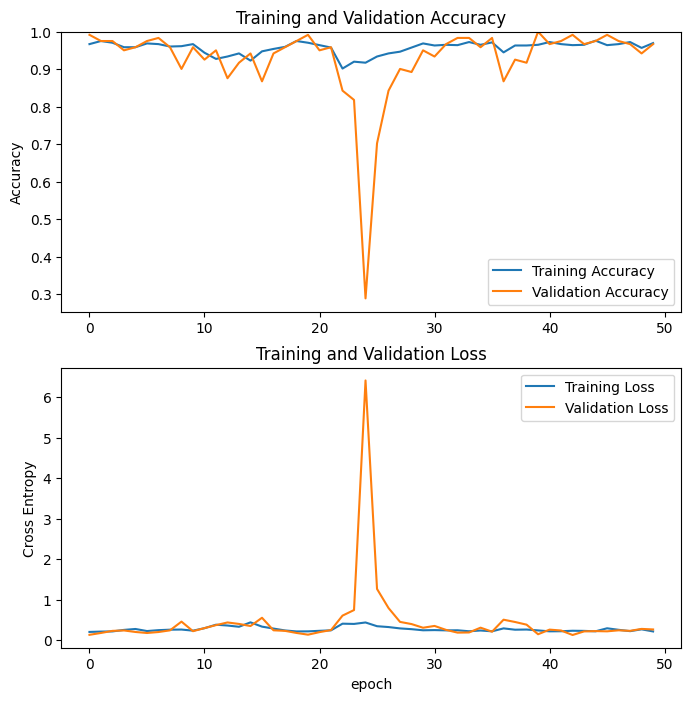

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [97]:
cnn_model = keras.models.load_model("models/prod/cnn_model.keras", compile=True)

In [108]:
cnn_model.evaluate(val_dataset)

2/2 [==============================] - 0s 8ms/step - loss: 0.1633 - accuracy: 0.9669


[0.1632707715034485, 0.9669421315193176]

In [109]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in val_dataset:
    test_labels += list(labels.numpy())
    pred_logits = cnn_model.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

2/2 [==============================] - 0s 3ms/step


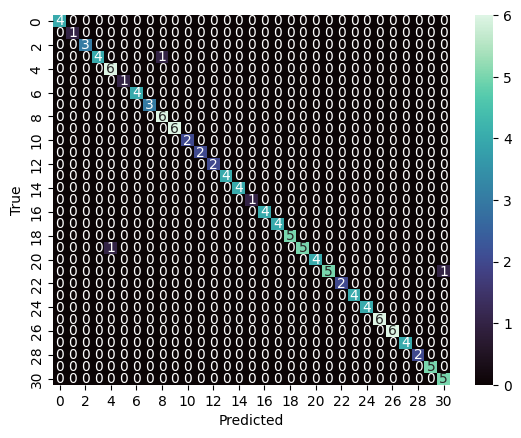

In [110]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

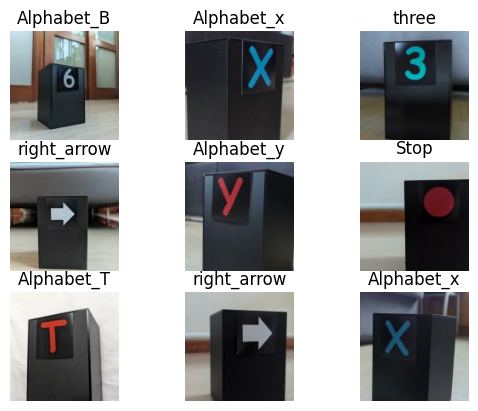

In [112]:
images, labels = next(iter(val_dataset))
preds = cnn_model(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

### CNN depthwise convolution

In [19]:
cnn_model_dw = keras.models.load_model("models/testing/cnn_model_dw.keras", compile=True)

In [20]:
cnn_model_dw.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 separable_conv2d (Separable  (None, 126, 126, 16)     91        
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 61, 61, 32)       688       
 leConv2D)                                            

In [21]:
cnn_model_dw.evaluate(val_dataset)

2/2 [==============================] - 3s 11ms/step - loss: 0.3778 - accuracy: 0.9421


[0.3778170645236969, 0.942148745059967]

In [22]:
optimizer = keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)

In [23]:
cnn_model_dw.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [24]:
checkpoint_filepath = 'models/prod/cnn_model_dw.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [25]:
epochs = 50

history = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs, 
  callbacks=[model_checkpoint_callback]
)

Epoch 1/50


18/18 [==============================] - 21s 924ms/step - loss: 0.4945 - accuracy: 0.9128 - val_loss: 0.4181 - val_accuracy: 0.9256
Epoch 2/50
18/18 [==============================] - 16s 881ms/step - loss: 0.4948 - accuracy: 0.8991 - val_loss: 0.4184 - val_accuracy: 0.9421
Epoch 3/50
18/18 [==============================] - 17s 904ms/step - loss: 0.5040 - accuracy: 0.8936 - val_loss: 0.4756 - val_accuracy: 0.9339
Epoch 4/50
18/18 [==============================] - 16s 887ms/step - loss: 0.5212 - accuracy: 0.8945 - val_loss: 0.5215 - val_accuracy: 0.9174
Epoch 5/50
18/18 [==============================] - 16s 859ms/step - loss: 0.5098 - accuracy: 0.9064 - val_loss: 0.4420 - val_accuracy: 0.9091
Epoch 6/50
18/18 [==============================] - 16s 873ms/step - loss: 0.5047 - accuracy: 0.9009 - val_loss: 0.4025 - val_accuracy: 0.9256
Epoch 7/50
18/18 [==============================] - 16s 876ms/step - loss: 0.5071 - accuracy: 0.8991 - val_loss: 0.4371 - val_accuracy: 0.9256
Epoch 8/50

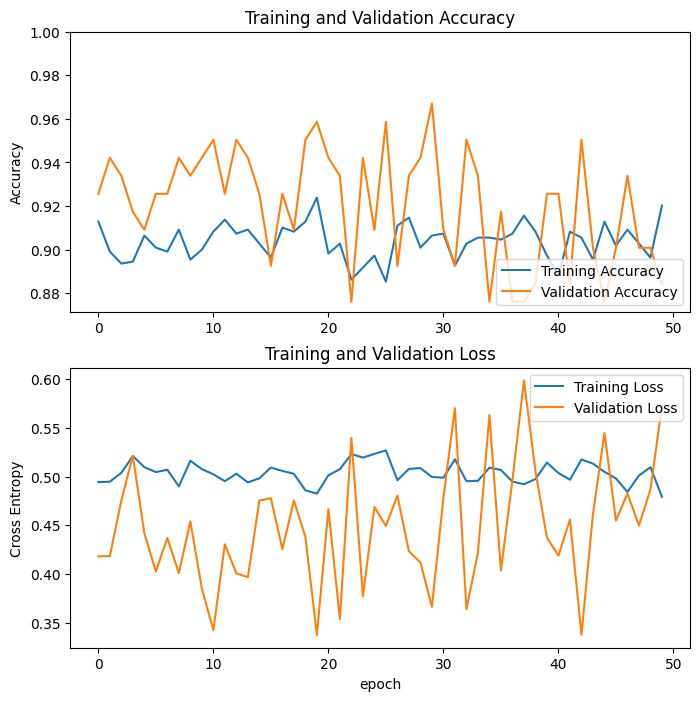

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
cnn_model_dw = keras.models.load_model("models/prod/cnn_model_dw.keras", compile=True)

In [30]:
cnn_model_dw.evaluate(val_dataset)

2/2 [==============================] - 0s 9ms/step - loss: 0.3916 - accuracy: 0.9587


[0.39159050583839417, 0.9586777091026306]

In [31]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in val_dataset:
    test_labels += list(labels.numpy())
    pred_logits = cnn_model_dw.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

2/2 [==============================] - 0s 4ms/step


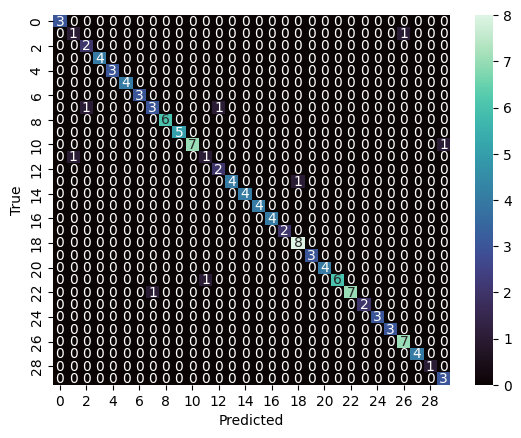

In [32]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

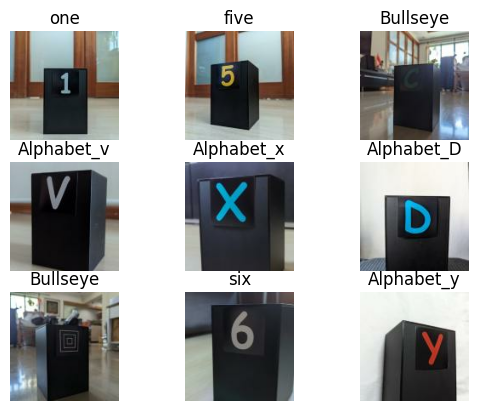

In [33]:
images, labels = next(iter(val_dataset))
preds = cnn_model_dw(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

### Finetune pretrained model

In [34]:
img_shape = (128, 128, 3)

In [35]:
mobnetv3_ft= keras.models.load_model("models/testing/mobnetv3_ft.keras", compile=True)

In [36]:
mobnetv3_ft.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 31)               

In [37]:
mobnetv3_ft.evaluate(val_dataset)

2/2 [==============================] - 16s 20ms/step - loss: 0.0929 - accuracy: 0.9752


[0.0929122045636177, 0.9752066135406494]

In [38]:
optimizer = keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)

In [39]:
checkpoint_filepath = 'models/prod/mobnetv3_ft.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [40]:
mobnetv3_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs = 25

history_mobnet = mobnetv3_ft.fit(train_dataset,
                                epochs=epochs,
                                validation_data=val_dataset, 
                                callbacks=[model_checkpoint_callback])

Epoch 1/25


18/18 [==============================] - 26s 938ms/step - loss: 0.1672 - accuracy: 0.9477 - val_loss: 0.0993 - val_accuracy: 0.9752
Epoch 2/25
18/18 [==============================] - 20s 1s/step - loss: 0.1660 - accuracy: 0.9560 - val_loss: 0.0947 - val_accuracy: 0.9835
Epoch 3/25
18/18 [==============================] - 21s 1s/step - loss: 0.1720 - accuracy: 0.9532 - val_loss: 0.0560 - val_accuracy: 0.9917
Epoch 4/25
18/18 [==============================] - 21s 1s/step - loss: 0.1587 - accuracy: 0.9523 - val_loss: 0.0478 - val_accuracy: 0.9917
Epoch 5/25
18/18 [==============================] - 21s 1s/step - loss: 0.1598 - accuracy: 0.9505 - val_loss: 0.0317 - val_accuracy: 1.0000
Epoch 6/25
18/18 [==============================] - 17s 921ms/step - loss: 0.1654 - accuracy: 0.9523 - val_loss: 0.1269 - val_accuracy: 0.9669
Epoch 7/25
18/18 [==============================] - 17s 934ms/step - loss: 0.1607 - accuracy: 0.9495 - val_loss: 0.0775 - val_accuracy: 0.9835
Epoch 8/25
18/18 [====

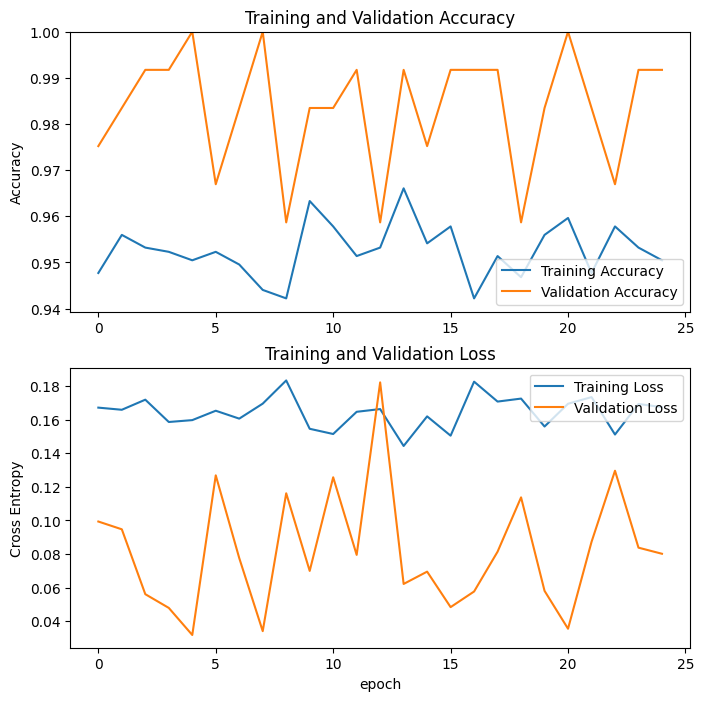

In [42]:
acc = history_mobnet.history['accuracy']
val_acc = history_mobnet.history['val_accuracy']

loss = history_mobnet.history['loss']
val_loss = history_mobnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
mobnetv3_ft = keras.models.load_model("models/prod/mobnetv3_ft.keras", compile=True)

In [49]:
mobnetv3_ft.evaluate(val_dataset)

2/2 [==============================] - 0s 16ms/step - loss: 0.0384 - accuracy: 1.0000


[0.0383928082883358, 1.0]

In [44]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in val_dataset:
    test_labels += list(labels.numpy())
    pred_logits = mobnetv3_ft.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

2/2 [==============================] - 1s 13ms/step


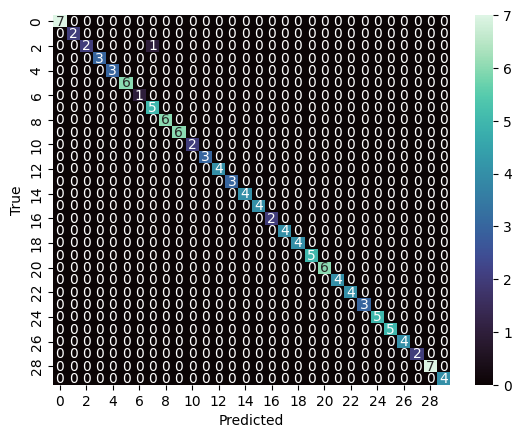

In [45]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

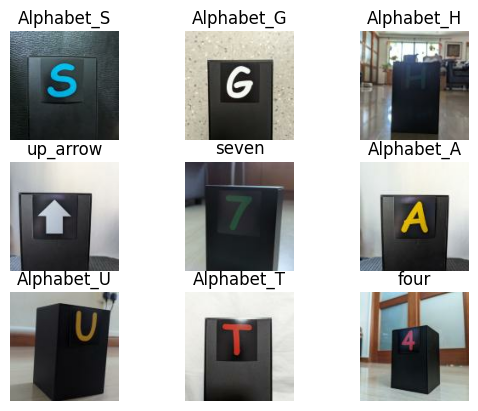

In [53]:
images, labels = next(iter(val_dataset))
preds = mobnetv3_ft(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

#### effnet

In [99]:
img_shape = (128, 128, 3)

In [112]:
effnetv2_ft = keras.models.load_model("models/testing/effnetv2_ft.keras", compile=True)

In [101]:
effnetv2_ft.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 31)               

In [102]:
effnetv2_ft.evaluate(val_dataset)

2/2 [==============================] - 1s 29ms/step - loss: 0.0106 - accuracy: 1.0000


[0.010578376241028309, 1.0]

In [113]:
effnetv2_ft.evaluate(train_dataset)

18/18 [==============================] - 2s 29ms/step - loss: 0.0118 - accuracy: 1.0000


[0.011812705546617508, 1.0]

In [107]:
optimizer = keras.optimizers.SGD(learning_rate=0.000001, momentum=0.9)

In [108]:
checkpoint_filepath = 'models/prod/effnetv2_ft.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [109]:
effnetv2_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [110]:
epochs = 10

history_effnet = effnetv2_ft.fit(train_dataset,
                                epochs=epochs,
                                validation_data=val_dataset, 
                                callbacks=[model_checkpoint_callback])

Epoch 1/10


18/18 [==============================] - 40s 2s/step - loss: 0.0353 - accuracy: 0.9936 - val_loss: 0.0334 - val_accuracy: 0.9917
Epoch 2/10
18/18 [==============================] - 29s 2s/step - loss: 0.0432 - accuracy: 0.9927 - val_loss: 0.0303 - val_accuracy: 0.9917
Epoch 3/10
18/18 [==============================] - 29s 2s/step - loss: 0.0484 - accuracy: 0.9917 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 18s 960ms/step - loss: 0.0421 - accuracy: 0.9936 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 17s 917ms/step - loss: 0.0465 - accuracy: 0.9927 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 17s 925ms/step - loss: 0.0501 - accuracy: 0.9917 - val_loss: 0.0338 - val_accuracy: 0.9917
Epoch 7/10
18/18 [==============================] - 17s 914ms/step - loss: 0.0462 - accuracy: 0.9927 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 8/10
18/18 [=

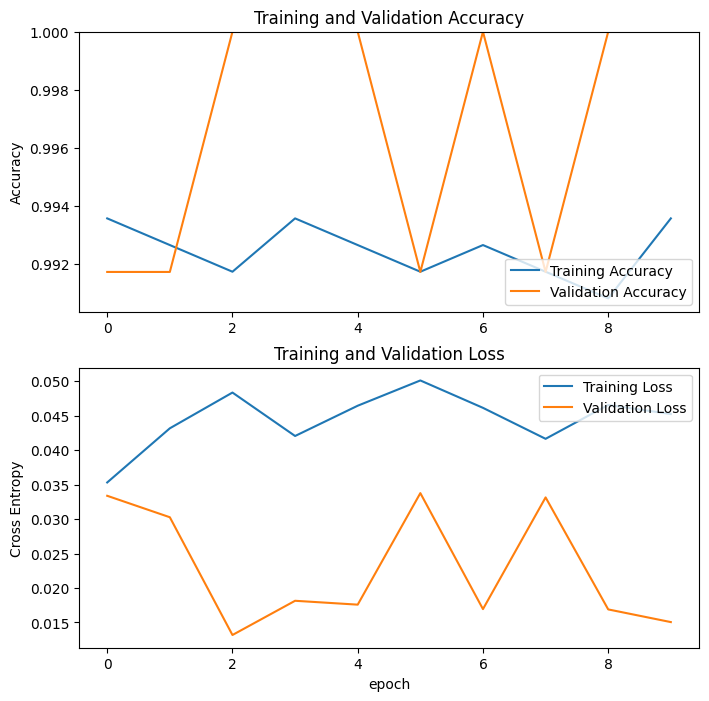

In [111]:
acc = history_effnet.history['accuracy']
val_acc = history_effnet.history['val_accuracy']

loss = history_effnet.history['loss']
val_loss = history_effnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [115]:
effnetv2_ft = keras.models.load_model("models/testing/effnetv2_ft.keras", compile=True)
effnetv2_ft.save("./models/prod/effnetv2_ft.keras")

In [116]:
effnetv2_ft = keras.models.load_model("models/prod/effnetv2_ft.keras", compile=True)

In [122]:
effnetv2_ft.evaluate(full_dataset.batch(64))

19/19 [==============================] - 2s 32ms/step - loss: 0.0115 - accuracy: 1.0000


[0.011514781042933464, 1.0]

In [117]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in val_dataset:
    test_labels += list(labels.numpy())
    pred_logits = effnetv2_ft.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

2/2 [==============================] - 1s 55ms/step


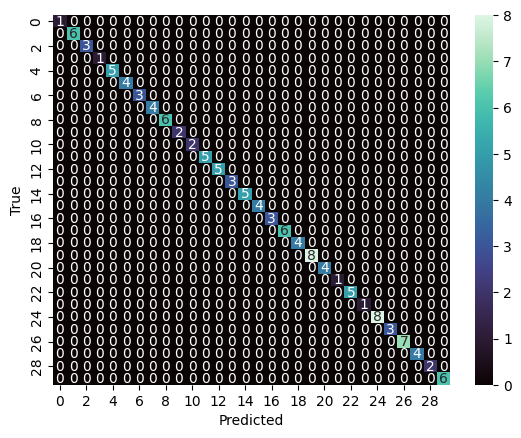

In [118]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

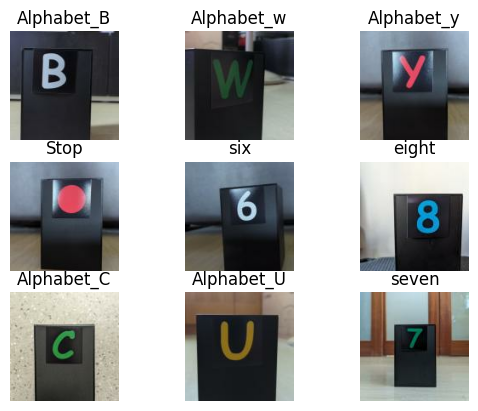

In [119]:
images, labels = next(iter(val_dataset))
preds = effnetv2_ft(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

##### Testing

In [123]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [124]:
import cv2
import os

path = "photos/prod_test"
files_list = [f for f in os.listdir(path) if os.path.isfile(f"{path}/{f}")]
print(files_list)

['Alphabet_A_33.jpg', 'Alphabet_B_33.jpg', 'Alphabet_C_33.jpg', 'Alphabet_D_33.jpg', 'Alphabet_E_33.jpg', 'Alphabet_F_33.jpg', 'Alphabet_G_33.jpg', 'Alphabet_H_33.jpg', 'Alphabet_S_33.jpg', 'Alphabet_T_33.jpg', 'Alphabet_U_33.jpg', 'Alphabet_v_33.jpg', 'Alphabet_w_33.jpg', 'Alphabet_x_33.jpg', 'Alphabet_y_33.jpg', 'Alphabet_z_33.jpg', 'Bullseye_33.jpg', 'Bullseye_34.jpg', 'down_arrow_33.jpg', 'eight_33.jpg', 'five_33.jpg', 'four_33.jpg', 'left_arrow_33.jpg', 'nine_33.jpg', 'one_33.jpg', 'right_arrow_33.jpg', 'right_arrow_34.jpg', 'seven_33.jpg', 'six_33.jpg', 'Stop_33.jpg', 'three_33.jpg', 'two_33.jpg', 'up_arrow_33.jpg']


In [125]:
len(files_list)

33

In [126]:
from PIL import Image

(new_width, new_height) = (128, 128)

for file in files_list:
  with Image.open(f"{path}/{file}") as im:
        width, height = im.size
        if height >= width:
            left = 0
            top = (height-width)/2
            right = width
            bottom = width+(height-width)/2
        else:
            left = (width-height)/2
            top = 0
            right = height+(width-height)/2
            bottom = height
        im_cropped = im.crop((left, top, right, bottom))
        im_resized = im_cropped.resize((new_width, new_height), resample=Image.HAMMING)
        im_resized.save(f"photos/prod_test/resized/{file}")
  
  

In [127]:
full_dataset_batched = full_dataset.batch(64)

In [128]:
import cv2


for file in files_list:
  image = cv2.imread(f"photos/prod_test/resized/{file}")

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cols, rows = gray.shape
  brightness = np.sum(image) / (255 * cols * rows)
  minimum_brightness = 0.8
  ratio = brightness / minimum_brightness

  if ratio < 1:
    scale_abs = cv2.convertScaleAbs(image, alpha = 1 / ratio, beta = 0)
    cv2.imwrite(f"photos/prod_test/processed/{file}", scale_abs)
  
  else:
    cv2.imwrite(f"photos/prod_test/processed/{file}", image)


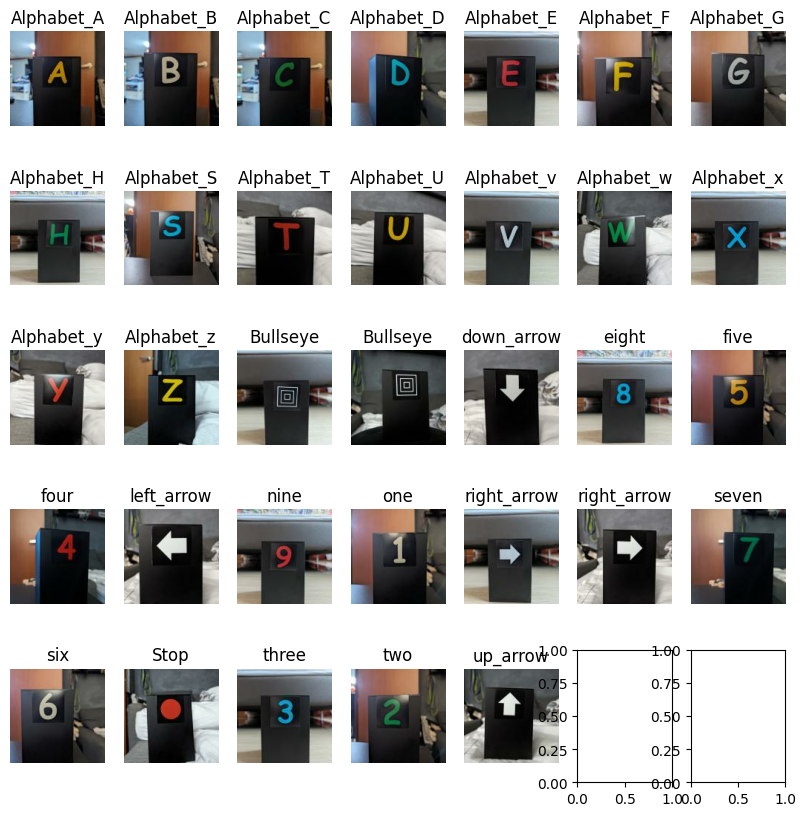

In [129]:
cnn_model= keras.models.load_model("models/prod/cnn_model.keras", compile=True)

fig, axs = plt.subplots(5, 7, figsize=(10,10))
ax = axs.ravel()

i = 0
for file in files_list:
  img = tf.image.decode_jpeg(tf.io.read_file(f"photos/prod_test/resized/{file}"), channels=3)/255
  img = tf.cast(img, tf.float32)
  img_batch = np.expand_dims(img, axis=0)
  logits = cnn_model(img_batch)
  pred = int(tf.math.argmax(logits, axis=1)[0])
  ax[i].imshow(img)
  ax[i].set_title(classes[pred])
  ax[i].axis("off")
  i += 1



In [130]:
cnn_model.evaluate(full_dataset_batched)

19/19 [==============================] - 1s 8ms/step - loss: 0.2081 - accuracy: 0.9661


[0.20814594626426697, 0.9661436676979065]

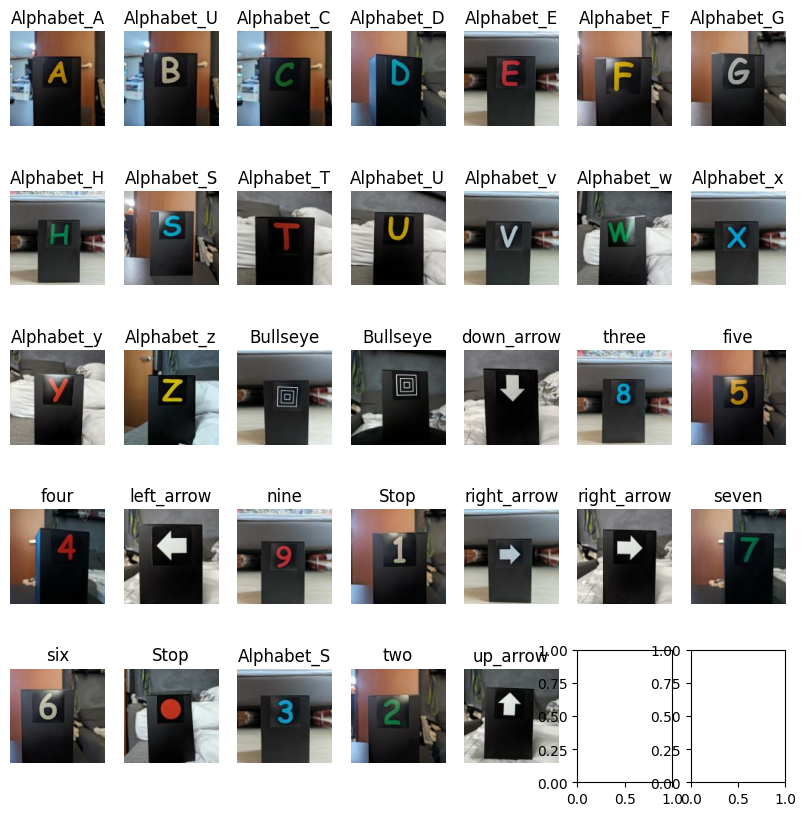

In [131]:
cnn_model_dw= keras.models.load_model("models/prod/cnn_model_dw.keras", compile=True)

fig, axs = plt.subplots(5, 7, figsize=(10,10))
ax = axs.ravel()

i = 0
for file in files_list:
  img = tf.image.decode_jpeg(tf.io.read_file(f"photos/prod_test/resized/{file}"), channels=3)/255
  img = tf.cast(img, tf.float32)
  img_batch = np.expand_dims(img, axis=0)
  logits = cnn_model_dw(img_batch)
  pred = int(tf.math.argmax(logits, axis=1)[0])
  ax[i].imshow(img)
  ax[i].set_title(classes[pred])
  ax[i].axis("off")
  i += 1



In [132]:
cnn_model_dw.evaluate(full_dataset_batched)

19/19 [==============================] - 1s 8ms/step - loss: 0.4219 - accuracy: 0.9323


[0.4219031035900116, 0.9322873950004578]

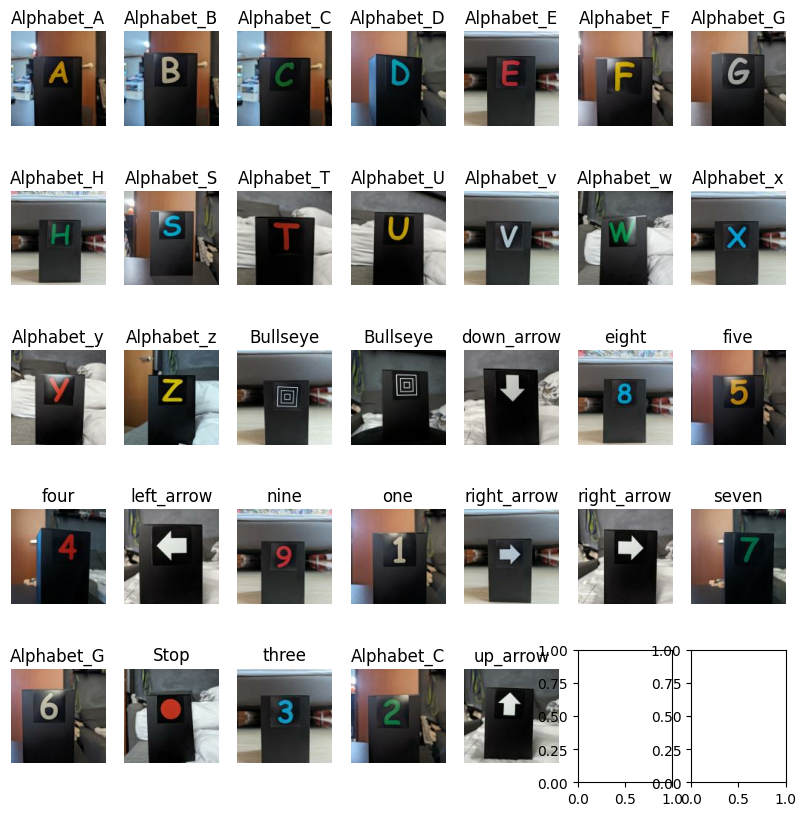

In [133]:

mobnetv3_ft= keras.models.load_model("models/prod/mobnetv3_ft.keras", compile=True)

fig, axs = plt.subplots(5, 7, figsize=(10,10))
ax = axs.ravel()

i = 0
for file in files_list:
  img = tf.image.decode_jpeg(tf.io.read_file(f"photos/prod_test/resized/{file}"), channels=3)/255
  img = tf.cast(img, tf.float32)
  img_batch = np.expand_dims(img, axis=0)
  logits = mobnetv3_ft(img_batch)
  pred = int(tf.math.argmax(logits, axis=1)[0])
  ax[i].imshow(img)
  ax[i].set_title(classes[pred])
  ax[i].axis("off")
  i += 1


In [134]:
mobnetv3_ft.evaluate(full_dataset_batched)

19/19 [==============================] - 1s 15ms/step - loss: 0.0852 - accuracy: 0.9810


[0.08522920310497284, 0.98100745677948]

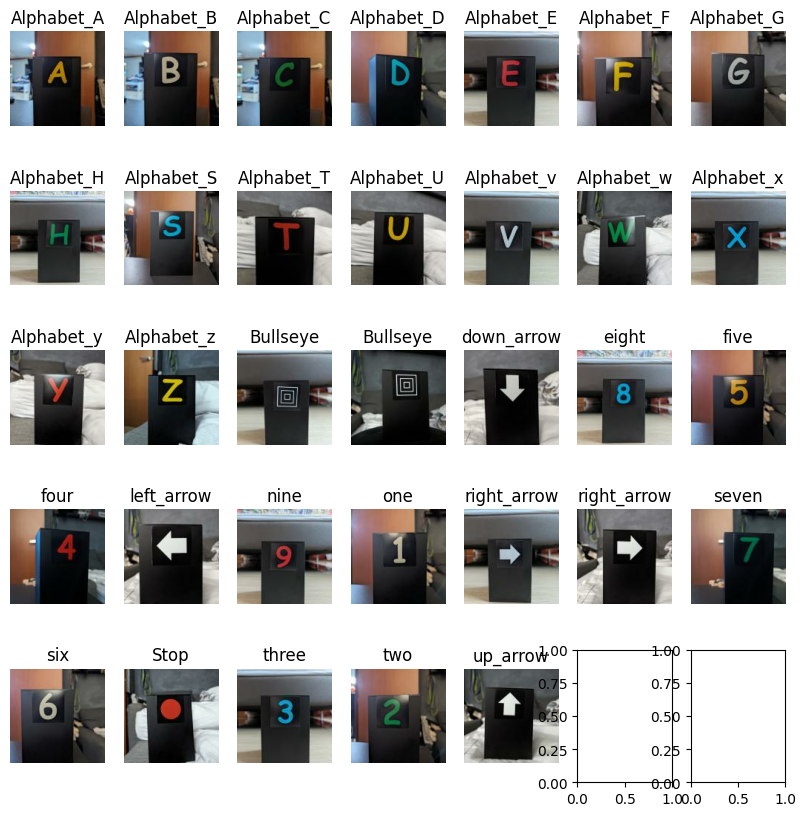

In [137]:

effnetv2_ft= keras.models.load_model("models/prod/effnetv2_ft.keras", compile=True)

fig, axs = plt.subplots(5, 7, figsize=(10,10))
ax = axs.ravel()

i = 0
for file in files_list:
  img = tf.image.decode_jpeg(tf.io.read_file(f"photos/prod_test/resized/{file}"), channels=3)/255
  img = tf.cast(img, tf.float32)
  img_batch = np.expand_dims(img, axis=0)
  logits = effnetv2_ft(img_batch)
  pred = int(tf.math.argmax(logits, axis=1)[0])
  ax[i].imshow(img)
  ax[i].set_title(classes[pred])
  ax[i].axis("off")
  i += 1


In [138]:
effnetv2_ft.evaluate(full_dataset_batched)

19/19 [==============================] - 11s 33ms/step - loss: 0.0115 - accuracy: 1.0000


[0.011514442041516304, 1.0]